# Long-Short-Term Memory (LSTM)

In this document we will create an LSTM to learn the growth in aircraft passenger traffice from 1949 to 1960, to make predictions for passenger growth in the following months.

        
## Loading the Dataset

The data is in airline-passengers.csv which is provided in this lecture. We will import it into a Pandas dataframe and look at it:


In [ ]:
import pandas as pd

# We don't need column 0 as it shows the month. Only interested in 
# column 1 which contains passenger numbers for the month/
dataframe = pd.read_csv('airline-passengers.csv', usecols = [1], engine = 'python')
print(dataframe)


Let's use pyplot to plot the data:

In [ ]:
import matplotlib.pyplot as plt

dataframe.plot(y = 'Passengers')
plt.show()

This shows a very typical time series that shows a trend (upward) as well as seasonal spikes (big bumps) and noise (little bumps). This should be great for our LSTM!

We now scale the data to between 0 and 1:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

dataset = dataframe.values

# Change to float32 and scale to 0 to 1
# scaled_value = (value - min) / (max - min)
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range = (0, 1))
dataset = scaler.fit_transform(dataset)

print(dataset)

Let's now import all the libraries that we need.

In [ ]:
import numpy
import math

# Bring in the Sequential model

from tensorflow.keras.models import Sequential

# Now bring in our main star: the LSTM network, and the
# Dense layer to incorporate the results of the LSTM nodes

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## Data and Training Configuration

We now create some hyperparameter constants. Explanations are in the comments.


In [ ]:
"""
Adjust these to control # of epochs, etc.
"""
batch_size = 1
look_back = 5
skip = 1
hidden_size = 128
num_epochs = 10
TRAIN_PERCENT = 0.67

# Set the random number seed so that we have reproducible results
numpy.random.seed(7)

## Generating Data

Now we will create a data generator to produce the test data. This generator takes the sample data we got out of our Pandas dataframe and scaled, and produces a window of data together with the target output. 

The "look_back" parameter controls the size of the input window. For example, suppose we have a time series of 1, 7, 3, 5, 2, 15, 12, 6, 3. Then with a look_back of 1, we have:

| X   | Y |  
|:---:|:---:|
|1    |7    |
|7    |3    |
|3    |5    |
|5    |2    |
|2    |15   |
|15   |12   |
|12   |6    |
|6    |3    |

With a look_back of 3, we have:

| X     | Y   |  
|:-----:|:---:|
|1,7,3  |5    |
|7,3,5  |2    |
|3,5,2  |15   |
|5,2,15 |12   |
|2,15,12|6    |
|15,12,6|3    |

Here is the code for the data generator, together with code to set up the training and testing data:

In [ ]:
# Figure out how many vectors for training and how many for
# testing.

train_size = int(len(dataset) * TRAIN_PERCENT)
test_size = len(dataset) - train_size

# Slice the dataset accordingly
train, test  = dataset[:train_size], dataset[train_size:]

# Generate the datasets with the given look_back.
def create_dataset(dataset, look_back=look_back):
    dataX, dataY=[], []

    for i in range(len(dataset) - look_back - 1):
        a=dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

# Call create_dataset to make the training and testing sets.
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# shape[0] gives # of rows, shape[1] gives number of columns.
# So here we have shape[0] rows each of 1 input of shape[1] columns.
# Number of columns is our lookback.

trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## Creating the LSTM

Now that we have our data generator, let's actually create the LSTM. For simplicity we will use the Keras Sequential model. The data we created is presented as a row vector of "look_back" columns, so our LSTM should be configured to accept this.


In [ ]:
# Create our LSTM

model = Sequential()
model.add(LSTM(hidden_size, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Print a summary of our network
model.summary()

#Start training
model.fit(trainX, trainY, epochs=num_epochs, batch_size=batch_size, verbose=2)

## Testing our Model

We can now call "predict" on our test and train data and print out the first 10 training and testing predictions:

In [ ]:
trainPredict=model.predict(trainX)
testPredict = model.predict(testX)

print("\nTraining prediction:\n", trainPredict[:10])
print("\nTesting prediction:\n", testPredict[:10])

As we can see we we get back a 2D array, consisting of many rows of a single column. We also see that the values are scaled between 0 and 1, and we need to rescale them back to the original. Let's do this now:



In [ ]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

print("Training Actual:\n", trainY[0,:10])
print("Training Predictions:\n", trainPredict[:10])
print("Testing Actual:\n", testY[0,:10])
print("Testing Predictions:\n", testPredict[:10])


We can see that the actual training and testing labels is a 2D array consisting of a single row with every label, while the predictions are a 2D array of many rows, where each row has one column, which is our prediction. We will call math.sqrt and numpy.mean_squared_error to find the RMSE, taking into account the differences in format:

In [ ]:
# Actual: A single row of many labels. Prediction: Many rows with a single value

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

## Changing the Input Format

Let's now change our LSTM's input format. Right now we have a single row of look_back inputs. To enable batching, we will now reconfigure our data so that we present "look_back" rows of one piece of data - our passenger numbers. This is how LSTM expects our inputs to be when we are batching them. The figure below shows this idea.

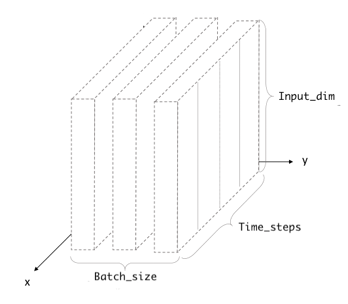

We also set a look_back of 5.

In [ ]:
look_back = 5

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Compare below with our original:
# trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))


## Creating our LSTM with Memory

The reason we want to batch our data is that it allows us to create an LSTM with memory - the LSTM is now able to learn across batches, not just across time steps within an input. We do this by setting the "stateful" parameter to True. Notice now that we present our data not as a single row of look_back values, but a batch of look_back rows, each with one piece of data. 

In [ ]:
model1 = Sequential()
model1.add(LSTM(128, batch_input_shape=(batch_size, look_back, 1), 
stateful = True))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')
model1.summary()


Wonderful, let's start training. We now have a complication in that model states have to be reset between batches. So now rather than training automatically for a number of epochs, we train for one epoch, clear the state, then go to the next epoch.

In [ ]:
for i in range(num_epochs):
    print("Iter: %d of %d" % (i, num_epochs))
    model1.fit(trainX, trainY, epochs=1, batch_size = batch_size, verbose = 2, shuffle = False)
    model1.reset_states()

As before we evaluate our accuracy:

In [ ]:
trainPredict=model1.predict(trainX, batch_size = batch_size)
testPredict = model1.predict(testX, batch_size = batch_size)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Note we have already applied inverse transforms for trainY and testY.
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

## Stacking LSTMs

We will now create a stack of LSTMs - One LSTM will feed to the next LSTM, and the next LSTM will learn over a window of outputs from the earlier LSTM.

We will use the redefined data that we created in the previous section, and just recreate the model. 

Notice that in the first layer we set "return_sequences" to True.  This causes the first LSTM to return a sequence of look_back predictions, instead of the latest prediction, which is needed for the second layer.

In [ ]:
model2 = Sequential()
model2.add(LSTM(8, batch_input_shape=(batch_size, look_back, 1), 
stateful = True, return_sequences = True))
model2.add(LSTM(8, batch_input_shape=(batch_size, look_back, 1), stateful = True))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')


As before we train and print the RMSE:

In [ ]:
# We recreate all the data that was altered by inverse_transform
# Of course we could have just used different variable names.. 
# But anyway..

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Uncomment this and run again to see improvement to the RMSE
num_epochs = 1000

for i in range(num_epochs):
    print("Iter: %d of %d" % (i, num_epochs))
    model2.fit(trainX, trainY, epochs=1, batch_size = batch_size, verbose = 2, shuffle = False)
    model2.reset_states()



In [ ]:
# Compute the score

trainPredict=model2.predict(trainX, batch_size = batch_size)
testPredict = model2.predict(testX, batch_size = batch_size)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

We can see the RMSE is terrible! Change the num_epochs above to 850 and you will see much better results. This is because the model is now much more complicated and needs more iterations to converge.
